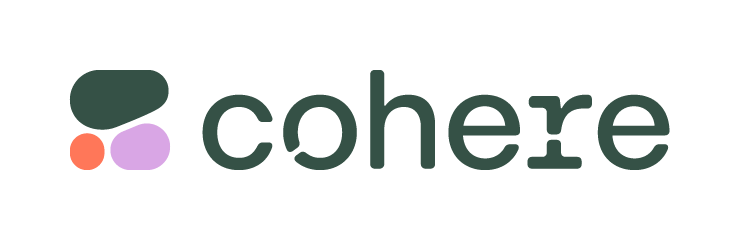

# Notebook Overview

## Motivation
Agents can play a crucial role in different enterprise scenarios. One such example is creating a request to fetch results from an existing enterprise API with specific requirements. For example, given a user query:

```Retrieve id 7410e652-639d-402e-984e-8fd7025f0aac 8bb21b93-2ddf-4a63-af63-ddb6b1be49a1, ref GLPNT0005GUJOGGE GLSBR000BGASOBRE, nmg 0000234GLCHL0200ARTINDIUS'```

The expected API request is:

```[{"uuid":["7410e652-639d-402e-984e-8fd7025f0aac","8bb21b93-2ddf-4a63-af63-ddb6b1be49a1"],"page":0,"size":10}, {"objref":["GLPNT0005GUJOGGE","GLSBR000BGASOBRE"],"page":0,"size":10},{"nmgs":["0000234GLCHL0200ARTINDIUS"],"page":0,"size":10}]```

This kind of task poses a major challenge, namely, the model must be very precise at identifying the codes in the query, based on their alphanumeric patterns, and matching these codes with the right parameter - for example, the code ```GLSBR000BGASOBRE``` needs to map to
```objref```. The task is even more challenging when multiple APIs are available, and the model has to deal with a plethora of parameters.

## Solution
In this notebook, we propose a simple but effective solution to the challenge defined above: We create a [Langchain ReAct Agent](https://github.com/langchain-ai/langchain-cohere/blob/main/libs/cohere/langchain_cohere/cohere_agent.py) that has access to a deterministic tool that extracts the alphanumeric patterns in the query, and returns a dictionary in which the keys are the parameters, and the values the extracted patterns. The output of the tool is then used to generate the final request.

Using such a tool is just one of the possibilities that the Agent has to generate the query: As we will see below, when a more semantic understanding of the query is required, we can ignore the tool and leverage the linguistic capabilities of the LLM powering the Agent to generate the final output.

With this approach, we bring together the best of two worlds: on the one hand, the ability of LLMs to use tool and generate outputs, on the other one, the reliability and efficiency of deterministic functions.

## Table of Contents

- [Step 1: Setup](#sec_step1)
- [Step 2: Define the Tool and the Agent](#sec_step2)
- [Step 3: Run the Agent](#sec_step3)
- [Conclusions](#sec_conclusion)
   

<a id="sec_step1"></a>
# Step 1: Setup

In [1]:
####################################################################################################
#
# Uncomment if you need to install the following packages
#
####################################################################################################

# !pip install cohere
# !pip install python-dotenv
# !pip install pandas


In [2]:
import os
import json
import re
import getpass
from langchain.agents import AgentExecutor
from langchain_cohere.chat_models import ChatCohere
from langchain_cohere.react_multi_hop.agent import create_cohere_react_agent
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.tools import tool

In [3]:
# load the cohere api key
os.environ["COHERE_API_KEY"] = getpass.getpass()

<a id="sec_step2"></a>
# Step 2: Define the Tool and the Agent
Here we create a tool which implements the deterministic function to extract alphanumeric strings from the user's query and match them to the right parameter.

In [4]:
@tool
def regex_extractor(user_query: str) -> dict:
    """Function which, given the query from the user, returns a dictionary parameter:value."""

    uuid = re.findall("\s([a-f0-9]{8}-[a-f0-9]{4}-[a-f0-9]{4}-[a-f0-9]{4}-[a-f0-9]{12})", user_query)
    nmgs = re.findall("(0000[A-Z0-9]{21})", user_query)
    objref = re.findall("\s([A-Z]{5,9}\d{3,4}[A-Z]{3,8})", user_query)
    urn = re.findall("urn:[a-f0-9]{8}-[a-f0-9]{4}-[a-f0-9]{4}-[a-f0-9]{4}-[a-f0-9]{12}",user_query,)
    d = {"uuid": uuid,
         "nmgs": nmgs,
         "objref": objref,
         "urn": urn}
    d_filtered = {k: v for k, v in d.items() if v != []}
    return d_filtered


class extract_code_v1productssearch(BaseModel):
    user_query: str = Field(
        description="This is the full input query as received from the user. Do not truncate or modify the query in any way."
    )

regex_extractor.name = "regex_extractor"
regex_extractor.args_schema = extract_code_v1productssearch
tools=[regex_extractor]

In [5]:
# Let's define the preamble for the Agent.
# The preamble includes info about:
# - the tool the Agent has access to
# - the cases in which the Agent has to produce an output without using the tool
# - some examples to clarify the task
preamble = """You are an assistant that given a user's query about, generates a request an API.
            You can use the tool named "regex_extractor".
            Pass to the "regex_extractor" tool the entire text of the the input query.
            The tool returns a dictionary, in which keys are the name of the codes, and values a list of extracted codes.
            Create a JSON for each of the key-value pairs in the dictionary.

            Return a list of JSONs. Make sure each JSON is properly defined. Do not return any other explanation or comment.
            You MUST generate a perfect JSON object: make sure that each string in the lists is included between quotes.

            If the request mentions one of the tags listed below, or a related word, create a dictionary in which the key is "taxonomies" and the value the list of capitalized tags.
            Tags list: cars, trucks, clothes, sport


            Find a list of examples here:
            User question | parameter for the tool | what you should understand
            Look products GLCMS004AGTCAMIS; 0000234GLCMS0100ANORAKCAA, GLCHL000CGUCHALE | Look products GLCMS004AGTCAMIS; 0000234GLCMS0100ANORAKCAA, GLCHL000CGUCHALE | [{"objref":["GLCMS004AGTCAMIS","GLCHL000CGUCHALE"]},{"nmgs":["0000234GLCMS0100ANORAKCAA"]}]
            Retrieve id 7410e652-639d-402e-984e-8fd7025f0aac 8bb21b93-2ddf-4a63-af63-ddb6b1be49a1, ref GLPNT0005GUJOGGE GLSBR000BGASOBRE, nmg 0000234GLCHL0200ARTINDIUS | Retrieve id 7410e652-639d-402e-984e-8fd7025f0aac 8bb21b93-2ddf-4a63-af63-ddb6b1be49a1, ref GLPNT0005GUJOGGE GLSBR000BGASOBRE, nmg 0000234GLCHL0200ARTINDIUS | [{"uuid":["7410e652-639d-402e-984e-8fd7025f0aac","8bb21b93-2ddf-4a63-af63-ddb6b1be49a1"]}, {"objref":["GLPNT0005GUJOGGE","GLSBR000BGASOBRE"]},{"nmgs":["0000234GLCHL0200ARTINDIUS"]}]
            Look for items of cars and trucks | Look for items of pants and t-shirts | [{'taxonomies': ['CARS', 'TRUCKS']}]
            Search products sport | Search products dress and jumpsuit | [{'taxonomies': ['SPORT']}]
            """

In [6]:
# Define the prompt
prompt = ChatPromptTemplate.from_template("{input}")

# Define the agent
llm = ChatCohere(model="command-r-plus", temperature=0)

# instantiate agent and agent executor
agent = create_cohere_react_agent(
   llm=llm,
   tools=tools,
   prompt=prompt,
)
agent_executor = AgentExecutor(agent=agent,
                               tools=tools,
                               verbose=True,
                               return_intermediate_steps=True
                    )

In [7]:
# finally, let's write a function to convert the Agents output to a json
def convert_to_json(string: str) -> json:
    return json.loads(
                string.replace("\xa0", " ")
                .replace("json", "")
                .replace("`", "")
                .replace("`", "")
            )


<a id="sec_step3"></a>
# Step 3: Run the Agent
Let's now test the Agent we just defined!

In [8]:
query_1 = "Look for urn:75f2b737-06dd-4399-9206-a6c11b65138e, GLCMS004AGTCAMIS; 0000234GLCMS0100ANORAKCAA, GLCHL000CGUCHALE"
response_1 = agent_executor.invoke(
            {
                "input": query_1,
                "preamble": preamble,
            }
        )



> Entering new AgentExecutor chain...

I will use the regex_extractor tool to extract the codes from the user query.
{'tool_name': 'regex_extractor', 'parameters': {'user_query': 'Look for urn:75f2b737-06dd-4399-9206-a6c11b65138e, GLCMS004AGTCAMIS; 0000234GLCMS0100ANORAKCAA, GLCHL000CGUCHALE'}}
{'nmgs': ['0000234GLCMS0100ANORAKCAA'], 'objref': ['GLCMS004AGTCAMIS', 'GLCHL000CGUCHALE'], 'urn': ['urn:75f2b737-06dd-4399-9206-a6c11b65138e']}Relevant Documents: 0
Cited Documents: 0
Answer: ```json
[
    {
        "urn": ["urn:75f2b737-06dd-4399-9206-a6c11b65138e"],
        "objref": ["GLCMS004AGTCAMIS", "GLCHL000CGUCHALE"],
        "nmgs": ["0000234GLCMS0100ANORAKCAA"]
    }
]
```
Grounded answer: ```json
 [
    {
        "urn": [<co: 0>"urn:75f2b737-06dd-4399-9206-a6c11b65138e</co: 0>"],
        "objref": [<co: 0>"GLCMS004AGTCAMIS</co: 0>", <co: 0>"GLCHL000CGUCHALE</co: 0>"],
        "nmgs": [<co: 0>"0000234GLCMS0100ANORAKCAA</co: 0>"]
    }
]
```

> Finished chain.


In the reasoning chain above, we can see that the Agent uses the tool we provided it to extract the strings in the query.
The output of the tool is then used to generate the request.

In [9]:
# let's have a look at the final output
convert_to_json(response_1['output'])

[{'urn': ['urn:75f2b737-06dd-4399-9206-a6c11b65138e'],
  'objref': ['GLCMS004AGTCAMIS', 'GLCHL000CGUCHALE'],
  'nmgs': ['0000234GLCMS0100ANORAKCAA']}]

As mentioned above, the Agent can use the tool when specific alphanumeric patterns have to be extracted from the query; however, it can also generate the output based on its semantic understanding of the query. For example:

In [10]:
query_2 = "I need tennis products"

response_2 = agent_executor.invoke(
    {
        "input": query_2,
        "preamble": preamble,
    }
)



> Entering new AgentExecutor chain...

I will use the regex_extractor tool to extract the relevant information from the user request.
{'tool_name': 'regex_extractor', 'parameters': {'user_query': 'I need tennis products'}}
{}Relevant Documents: None
Cited Documents: None
Answer: ```json
[
    {
        "taxonomies": [
            "SPORT"
        ]
    }
]
```
Grounded answer: ```json
 [
 {
 "taxonomies": [
 "SPORT"
 ]
 }
]
```

> Finished chain.


The Agent run the tool to check if any target string was in the query, then it generated the request body based on its understanding.

In [11]:
convert_to_json(response_2['output'])

[{'taxonomies': ['SPORT']}]

Finally, the two paths to generation - deterministic and semantic - can be applied in parallel by the Agent, as shown below:

In [12]:
query_3 = "Look for GLBRL0000GACHALE, nmg 0000234GLCZD0000GUREDTOAA and car products"

response_3 = agent_executor.invoke(
    {
        "input": query_3,
        "preamble": preamble,
    }
)



> Entering new AgentExecutor chain...

I will use the regex_extractor tool to extract the codes from the user query. Then, I will create a JSON for each of the key-value pairs in the dictionary.
{'tool_name': 'regex_extractor', 'parameters': {'user_query': 'Look for GLBRL0000GACHALE, nmg 0000234GLCZD0000GUREDTOAA and car products'}}
{'nmgs': ['0000234GLCZD0000GUREDTOAA'], 'objref': ['GLBRL0000GACHALE']}Relevant Documents: 0
Cited Documents: 0
Answer: ```json
[
    {
        "objref": ["GLBRL0000GACHALE"],
        "nmgs": ["0000234GLCZD0000GUREDTOAA"]
    },
    {
        "taxonomies": ["CARS"]
    }
]
```
Grounded answer: ```json
 [
    {
        "objref": [<co: 0>"GLBRL0000GACHALE</co: 0>"],
        "nmgs": [<co: 0>"0000234GLCZD0000GUREDTOAA</co: 0>"]
    },
    {
        "taxonomies": ["CARS"]
    }
]
```

> Finished chain.


In [13]:
convert_to_json(response_3['output'])

[{'objref': ['GLBRL0000GACHALE'], 'nmgs': ['0000234GLCZD0000GUREDTOAA']},
 {'taxonomies': ['CARS']}]

<a id="sec_conclusion"></a>
# Conclusions

In this notebook we showed how Agents can be used to solve a real-world use case, in which the goal is to create API requests based on the user's query. We did it by providing the Agent with a deterministic tool to extract relevant alphanumeric strings in the query, and matching them to the right parameter name. In parallel, the Agent can leverage the semantic understanding of the query provided by the LLM powering it.